In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%writefile helpers.py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
import random
from scipy.spatial.distance import euclidean


def plot_graph(G, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    pos = nx.shell_layout(G)
    nx.draw_networkx(G, pos, node_color="#CFEBF8")
    labels = {}
    dists = nx.get_edge_attributes(G,'distance')
    types = nx.get_edge_attributes(G,'type')
    for node_pair, v in dists.items():
        label = str(dists[node_pair])
        if types.get(node_pair):
            label += f' ({types[node_pair]})'
        labels[node_pair] = label
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.box(on=None)
    plt.show()


def get_may_link_pairs(num_prods: int, sim_threshold: float, seed: int):
    np.random.seed(seed)
    embeddings = np.random.rand(num_prods, 8).astype(np.float32)
    embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    for first, second in itertools.combinations(range(num_prods), 2):
        dist = euclidean(embeddings[first], embeddings[second]) / 2
        sim = 1.0 - dist
        if sim >= sim_threshold:
            yield (first, second, round(dist, 2))


def get_must_link_pairs_group_key(num_prods: int, num_pairs: int, seed: int):
    random.seed(seed)
    pairs = []
    for n in range(num_pairs):
        pairs.append(tuple(sorted(random.sample(range(num_prods), 2)) + [0.0]))
    return pairs


def get_must_link_pairs_gtin(num_prods: int, num_pairs: int, seed: int):
    random.seed(seed)
    pairs = []
    for n in range(num_pairs):
        pairs.append(tuple(sorted(random.sample(range(num_prods), 2)) + [0.0]))
    return pairs


def compute_transitive_closure(must_link_pairs):
    _G = nx.Graph()
    _G.add_weighted_edges_from(must_link_pairs, weight='distance')

    must_link_pairs_direct = []
    must_link_pairs_indirect = []
    
    for node_set in nx.connected_components(_G):
        for n1, n2 in itertools.combinations(sorted(node_set), 2):
            pair = (n1, n2, 0.0)
            if pair in must_link_pairs:
                must_link_pairs_direct.append(pair)
            else:
                must_link_pairs_indirect.append(pair)
    return must_link_pairs_direct, must_link_pairs_indirect


def fill_edges_with_shortest_paths(g, sim_threshold: int):
    edges_to_fill = []
    subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
    for sg in subgraphs:
        for n1, n2 in itertools.combinations(sorted(sg.nodes()), 2):
            if not sg.has_edge(n1, n2):
                dist = nx.shortest_path_length(sg, n1, n2, weight='distance')
                if dist <= 1 - sim_threshold:
                    edges_to_fill.append((n1, n2, dist))
    g.add_weighted_edges_from(edges_to_fill, weight='distance', type='indirect may')


def simulate_end_to_end(num_prods: int, sim_threshold: float, num_must_link_pairs: int, seed: int, figsize=(6, 6)):
    random.seed(seed)
    seed1 = random.randint(0, 100)
    seed2 = random.randint(0, 100)
    seed3 = random.randint(0, 100)
    
    num_group_key_matches = random.randint(0, num_must_link_pairs)
    num_gtin_matches = num_must_link_pairs - num_group_key_matches
    
    G = nx.Graph()
    G.add_weighted_edges_from(
        get_may_link_pairs(num_prods=num_prods, sim_threshold=sim_threshold, seed=seed1),
        weight='distance',
        type='direct may',
    )
    
    must_link_pairs = get_must_link_pairs_group_key(num_prods=num_prods, num_pairs=num_group_key_matches, seed=seed2) \
                      + get_must_link_pairs_gtin(num_prods=num_prods, num_pairs=num_gtin_matches, seed=seed3)
    
    must_link_pairs_direct, must_link_pairs_indirect = compute_transitive_closure(must_link_pairs)
    G.add_weighted_edges_from(must_link_pairs_direct, weight='distance', type='direct must')
    G.add_weighted_edges_from(must_link_pairs_indirect, weight='distance', type='indirect must')

    fill_edges_with_shortest_paths(G, sim_threshold=sim_threshold)
    plot_graph(G, figsize=figsize)


Writing helpers.py


In [ ]:
import networkx as nx
from helpers import (
    plot_graph,
    get_may_link_pairs,
    get_must_link_pairs_group_key,
    get_must_link_pairs_gtin,
    compute_transitive_closure,
    fill_edges_with_shortest_paths,
    simulate_end_to_end,
)

### Get some random (direct) "may link" pairs - image similarity
#### This is to simulate the output from our product matching model
- Generate `NUM_PRODUCTS` number of **RETAILER** products (each has an random L2 normalised image representation)
- Calculate pairwise euclidean distance, then scaled to [0, 1]
- Return those pairs with a similarity (= 1 - distance) above `SIM_THRESHOLD`

In [ ]:
NUM_PRODUCTS = 10
SIM_THRESHOLD = 0.8

print(list(get_may_link_pairs(num_prods=NUM_PRODUCTS, sim_threshold=SIM_THRESHOLD, seed=3)))

[(1, 6, 0.19), (1, 8, 0.16), (2, 5, 0.18), (3, 5, 0.14), (6, 8, 0.15)]


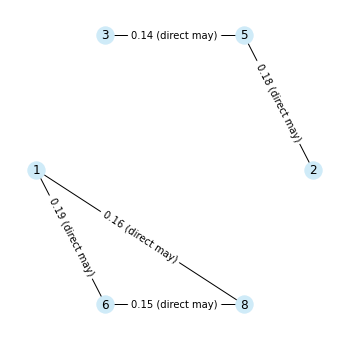

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(
    get_may_link_pairs(num_prods=NUM_PRODUCTS, sim_threshold=SIM_THRESHOLD, seed=3),
    weight='distance', type='direct may'
)

plot_graph(G)

### Among all possible pairs from the `NUM_PRODUCTS` products, randomly pick some (direct) "must link" pairs
#### This is to simulate other fact-based "judgement" techniques, or human merges as well

In [ ]:
print(f"Group key matches: {get_must_link_pairs_group_key(num_prods=NUM_PRODUCTS, num_pairs=2, seed=1)}")
print(f"GTIN matches:      {get_must_link_pairs_gtin(num_prods=NUM_PRODUCTS, num_pairs=1, seed=4)}")

Group key matches: [(1, 2, 0.0), (1, 4, 0.0)]
GTIN matches:      [(3, 4, 0.0)]


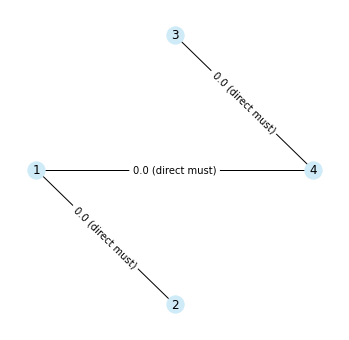

In [ ]:
must_link_pairs = get_must_link_pairs_group_key(num_prods=NUM_PRODUCTS, num_pairs=2, seed=1) \
                  + get_must_link_pairs_gtin(num_prods=NUM_PRODUCTS, num_pairs=1, seed=4)
_G = nx.Graph()
_G.add_weighted_edges_from(must_link_pairs, weight='distance', type='direct must')
plot_graph(_G)

### Based on the direct "must link" pairs, infer all indirect "must link" pairs
#### E.g. a==b, b==c -> a==c
#### NOTE: this transitive closure step is only for demo purposes, not an required part of the algo since indirect must links can be filled by shortest_path too.

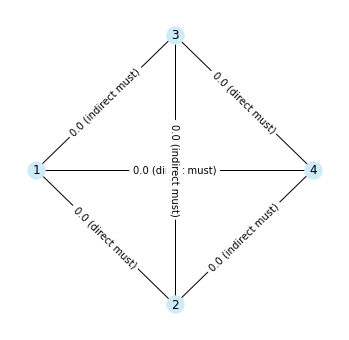

In [ ]:
must_link_pairs_direct, must_link_pairs_indirect = compute_transitive_closure(must_link_pairs)
_G = nx.Graph()
_G.add_weighted_edges_from(must_link_pairs_direct, weight='distance', type='direct must')
_G.add_weighted_edges_from(must_link_pairs_indirect, weight='distance', type='indirect must')
plot_graph(_G)

In [ ]:
must_link_pairs_direct

[(1, 2, 0.0), (1, 4, 0.0), (3, 4, 0.0)]

In [ ]:
must_link_pairs_indirect

[(1, 3, 0.0), (2, 3, 0.0), (2, 4, 0.0)]

In [ ]:
_G.adj

AdjacencyView({1: {2: {'type': 'direct must', 'distance': 0.0}, 4: {'type': 'direct must', 'distance': 0.0}, 3: {'type': 'indirect must', 'distance': 0.0}}, 2: {1: {'type': 'direct must', 'distance': 0.0}, 3: {'type': 'indirect must', 'distance': 0.0}, 4: {'type': 'indirect must', 'distance': 0.0}}, 4: {1: {'type': 'direct must', 'distance': 0.0}, 3: {'type': 'direct must', 'distance': 0.0}, 2: {'type': 'indirect must', 'distance': 0.0}}, 3: {4: {'type': 'direct must', 'distance': 0.0}, 1: {'type': 'indirect must', 'distance': 0.0}, 2: {'type': 'indirect must', 'distance': 0.0}}})

In [ ]:
list(nx.connected_components(_G))

[{1, 2, 3, 4}]

In [ ]:
for sg in [_G.subgraph(list(nx.connected_components(_G))[0])]:
    print(sg)

Graph with 4 nodes and 6 edges


In [ ]:
sg

### Combine all "must link" pairs (direct and indirect) and the previous direct "may link" pairs

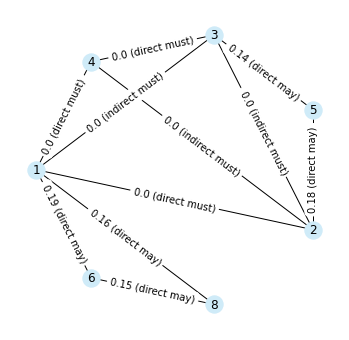

In [ ]:
G.add_weighted_edges_from(must_link_pairs_direct, weight='distance', type='direct must')
G.add_weighted_edges_from(must_link_pairs_indirect, weight='distance', type='indirect must')
plot_graph(G)

### Fill the missing edges (indirect "may link" pairs) on the graph when the shortest path between two retailer products is below `1 - SIMTHRESHOLD`

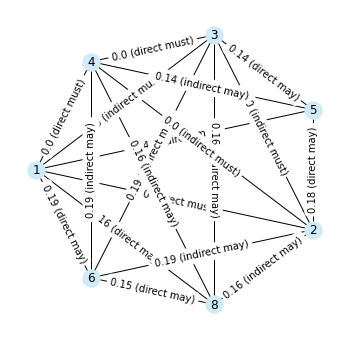

In [ ]:
fill_edges_with_shortest_paths(G, sim_threshold=SIM_THRESHOLD)
plot_graph(G)

### Verify that all pairs that exist have a small enough distance (< `1 - SIM_THRESHOLD`)

In [ ]:
all([attr['distance']  <= 1 - SIM_THRESHOLD for n1, n2, attr in G.edges.data()])

True

### Moar random simulations!

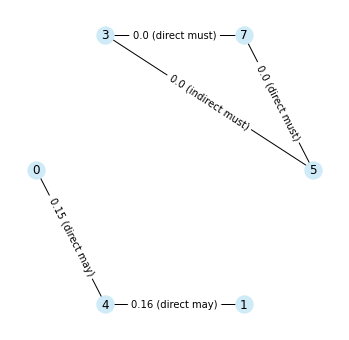

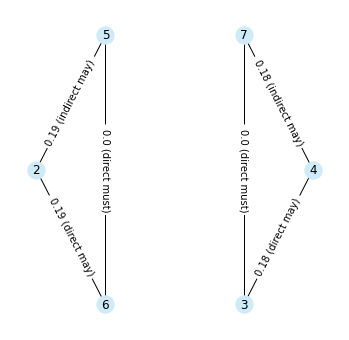

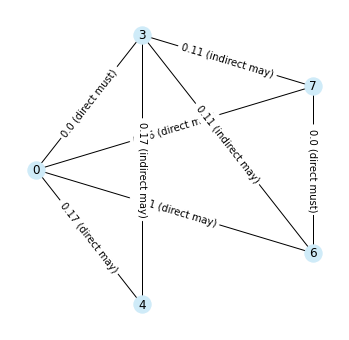

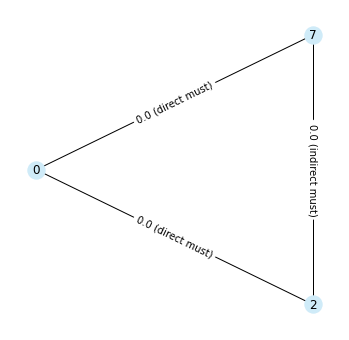

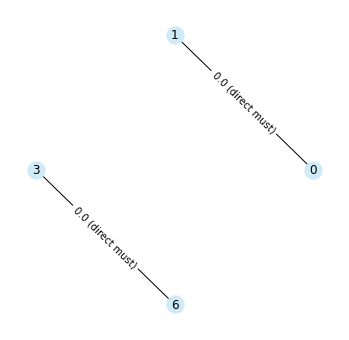

In [ ]:
for i in range(5):
    simulate_end_to_end(num_prods=8, num_must_link_pairs=2, sim_threshold=0.8, seed=i)
    print("\n\n\n")

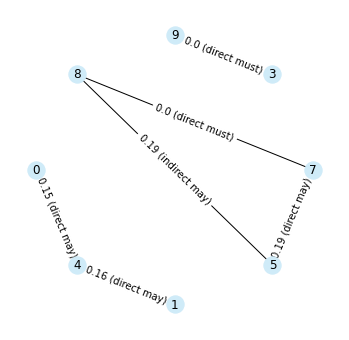

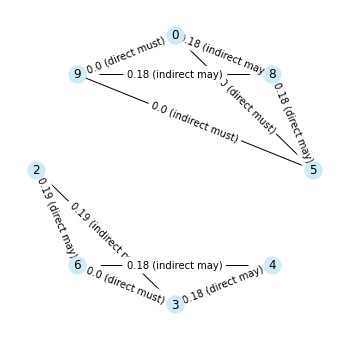

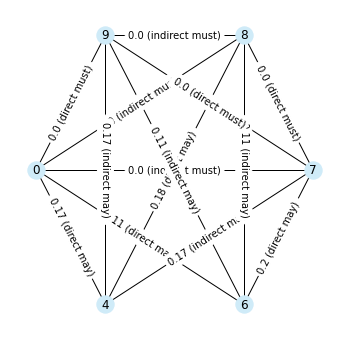

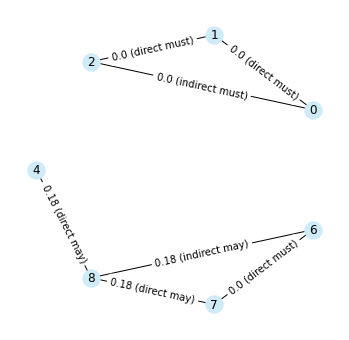

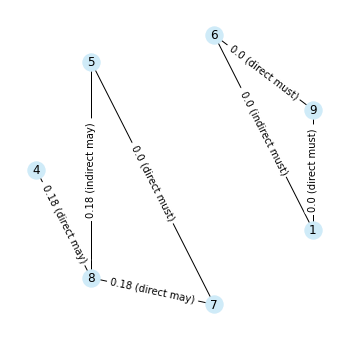

In [ ]:
for i in range(5):
    simulate_end_to_end(num_prods=10, num_must_link_pairs=3, sim_threshold=0.8, seed=i)
    print("\n\n\n")

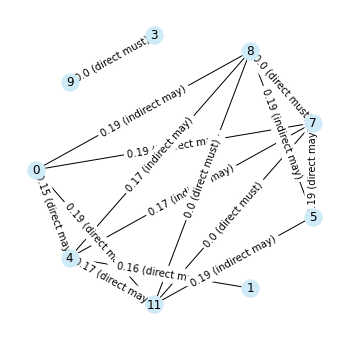

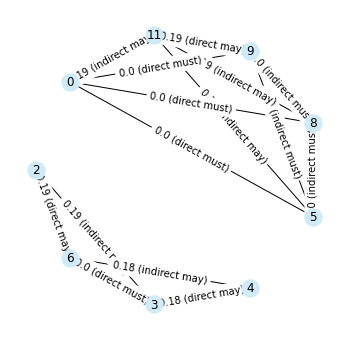

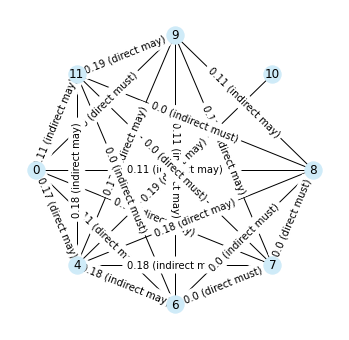

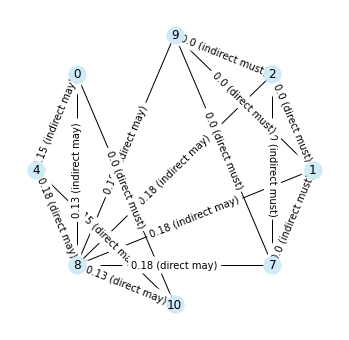

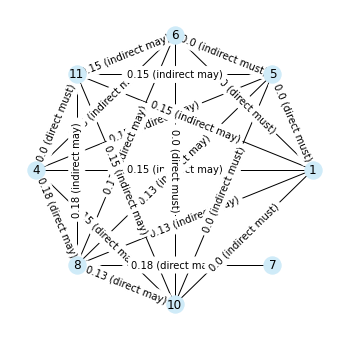

In [ ]:
for i in range(5):
    simulate_end_to_end(num_prods=12, num_must_link_pairs=4, sim_threshold=0.8, seed=i)
    print("\n\n\n")

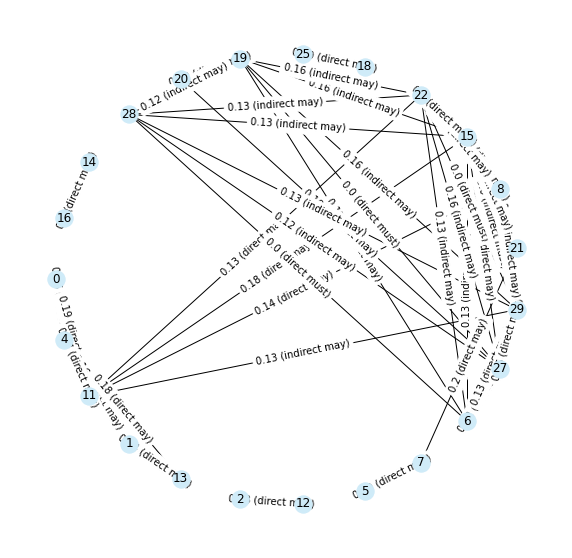

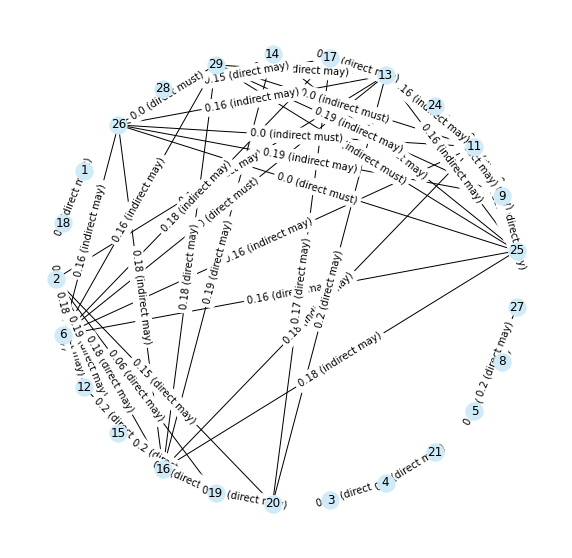

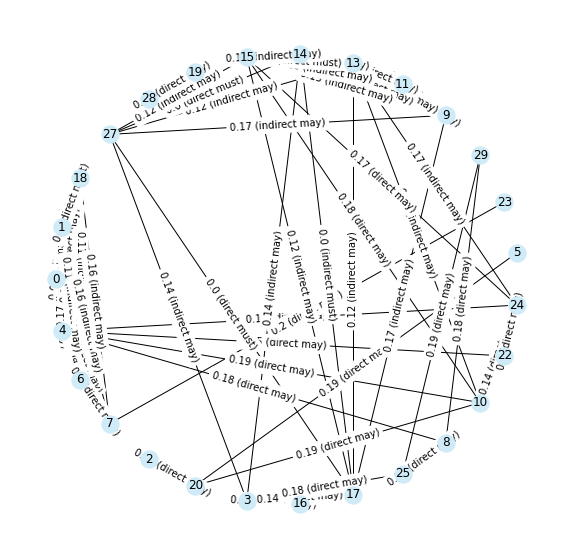

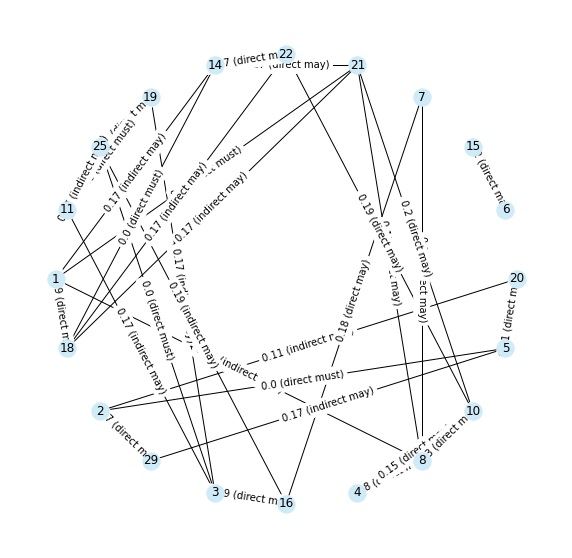

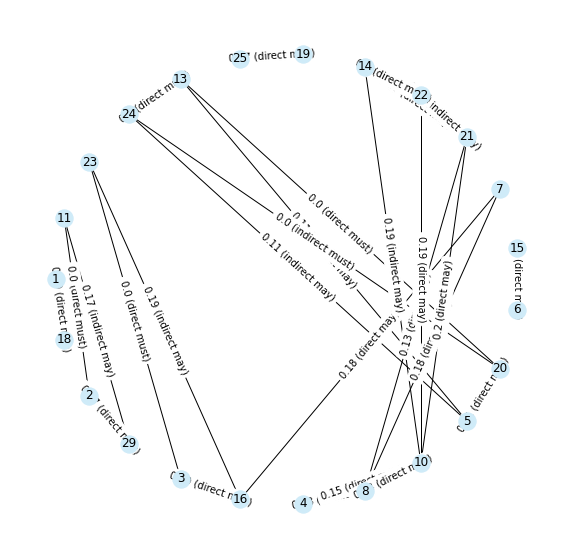

In [ ]:
for i in range(5):
    simulate_end_to_end(num_prods=30, num_must_link_pairs=5, sim_threshold=0.8, seed=i, figsize=(10, 10))
    print("\n\n\n")

In [ ]:
def connected_components(
    id_pairs, scores, distance_threshold
):
    """Perform connected components based on pairs from latest partition in Athena

    Args:
        id_pairs (Pairs): Pairs of entity IDs
        scores (Scores): Similarity scores
        distance_threshold (int): 1 - similarity_threshold

    Yields:
        Iterator[Tuple[Pairs, Scores]]: Sorted edges and their corresponding weights
    """
    G = nx.Graph()
    edgelist = ((id_a, id_b, score) for (id_a, id_b), score in zip(id_pairs, scores))
    G.add_weighted_edges_from(edgelist)

    edges_to_fill = []
    subgraphs = [G.subgraph(c) for c in nx.connected_components(G)]
    for sg in subgraphs:
        for n1, n2 in itertools.combinations(sorted(sg.nodes()), 2):
            if sg.has_edge(n1, n2):
                continue
            dist = nx.shortest_path_length(sg, n1, n2, weight="distance")
            if dist <= distance_threshold:
                edges_to_fill.append((n1, n2, dist))
    G.add_weighted_edges_from(edges_to_fill, weight="distance", type="indirect may")
    return G
    # for cc_nodes in nx.connected_components(G):
    #     G_sub = G.subgraph(cc_nodes)
    #     sorted_edges = SortedDict()
    #     for id_a, id_b, score in G_sub.edges(data="weight"):
    #         sorted_edges[tuple(sorted((id_a, id_b)))] = score
    #     yield list(sorted_edges.keys()), list(sorted_edges.values())

In [ ]:
import itertools
from sortedcontainers import SortedDict

id_pairs = [
        ("101", "102"),
        ("101", "103"),
        ("101", "104"),
        ("101", "105"),
        ("102", "103"),
        ("102", "104"),
        ("102", "105"),
        ("103", "104"),
        ("103", "105"),
        ("104", "105"),
        ("110", "111"),
        # add a short cut
        ()
        ]
scores = [0.86, 0.72, 0.2, 0.6, 0.86, 0.2, 0.72, 0.3, 0.5, 0.72, 0.9]
subgraph_edgelist = connected_components(id_pairs, scores, distance_threshold=1)
assert next(subgraph_edgelist) == (
    [
        ("101", "102"),
        ("101", "103"),
        ("101", "104"),
        ("101", "105"),
        ("102", "103"),
        ("102", "104"),
        ("102", "105"),
        ("103", "104"),
        ("103", "105"),
        ("104", "105"),
    ],
    [
        0.86,
        0.72,
        0.2,
        0.6,
        0.86,
        0.2,
        0.72,
        0.3,
        0.5,
        0.72,
    ],
)

TypeError: ignored

In [ ]:
id_pairs = [
        ("101", "102"),
        ("101", "103"),
        ("101", "104"),
        # ("101", "105"),
        ("102", "103"),
        ("102", "104"),
        ("102", "105"),
        ("103", "104"),
        ("103", "105"),
        ("104", "105"),  # shortcut
        ("110", "111"),
    ]

scores = [0.86, 0.72, 0.2, 0.86, 0.2, 0.72, 0.3, 0.5, 0, 0.9]

In [ ]:
import networkx as nx
from sortedcontainers import SortedDict

import itertools
from typing import Iterator, Tuple


In [ ]:
G = nx.Graph()
edgelist = ((id_a, id_b, score) for (id_a, id_b), score in zip(id_pairs, scores))
G.add_weighted_edges_from(edgelist)

In [ ]:
list(nx.connected_components(G))

[{'101', '102', '103', '104', '105'}, {'110', '111'}]

In [ ]:
subgraphs = [G.subgraph(c) for c in nx.connected_components(G)]

In [ ]:
subgraphs[0].nodes

NodeView(('101', '102', '103', '104', '105'))

In [ ]:
sg = subgraphs[0]

In [ ]:
nx.shortest_path_length(sg, "101", "105", weight="weight")

0.6

In [ ]:
sg.has_edge("101", "105")

True

In [ ]:
sg.has_edge("101", "104")

True

In [ ]:
sg.edges

EdgeView([('101', '102'), ('101', '103'), ('101', '104'), ('101', '105'), ('102', '103'), ('102', '104'), ('102', '105'), ('103', '104'), ('103', '105'), ('104', '105')])

In [ ]:
sorted_edges = SortedDict()

In [ ]:
sorted_edges = SortedDict()

In [ ]:
for i in nx.connected_components(G):
    i

In [ ]:
a = next(nx.connected_components(G))

In [ ]:
a

{'101', '102', '103', '104', '105'}

In [ ]:
G_sub = G.subgraph(a)

for id_a, id_b, score in G_sub.edges(data="weight"):
    sorted_edges[tuple(sorted((id_a, id_b)))] = score

In [ ]:
sorted_edges[('101', '102')]

0.86

In [ ]:
G_sub

In [ ]:
len(G.edges)

11

In [ ]:
id_pairs = [
        ("101", "102"),
        ("101", "103"),
        ("101", "104"),
        ("101", "105"),
        ("102", "103"),
        ("102", "104"),
        ("102", "105"),
        ("103", "104"),
        ("103", "105"),
        ("104", "105"),
    ]

In [ ]:
len(id_pairs)

10

In [ ]:
scores = [0.86, 0.72, 0.2, 0.86, 0.2, 0.72, 0.3, 0.5, 0]
len(scores)

9

In [ ]:
G.adj

AdjacencyView({'101': {'102': {'weight': 0.86}, '103': {'weight': 0.72}, '104': {'weight': 0.2}, '105': {'weight': 0.6}}, '102': {'101': {'weight': 0.86}, '103': {'weight': 0.86}, '104': {'weight': 0.2}, '105': {'weight': 0.72}}, '103': {'101': {'weight': 0.72}, '102': {'weight': 0.86}, '104': {'weight': 0.3}, '105': {'weight': 0.5}}, '104': {'101': {'weight': 0.2}, '102': {'weight': 0.2}, '103': {'weight': 0.3}, '105': {'weight': 0.72}}, '105': {'101': {'weight': 0.6}, '102': {'weight': 0.72}, '103': {'weight': 0.5}, '104': {'weight': 0.72}}, '110': {'111': {'weight': 0.9}}, '111': {'110': {'weight': 0.9}}})

In [ ]:
G.adjacency(["101"])

TypeError: ignored

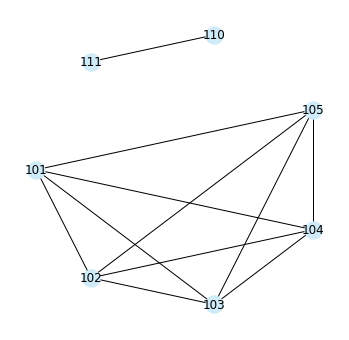

In [ ]:
plot_graph(G)

In [ ]:
id_pairs = [
        ("101", "102"),
        ("101", "103"),
        ("101", "104"),
        ("102", "103"),
        ("102", "104"),
        ("102", "105"),
        ("103", "104"),
        ("103", "105"),
        ("104", "105"),
        ("110", "111"),
    ]
scores = [0.86, 0.72, 0.2, 0.86, 0.2, 0.72, 0.3, 0.5, 0, 0.9]


In [ ]:
def build_graph(id_pairs, scores) -> nx.Graph:
    """build graph based on pairs from latest partition in Athena

    Args:
        id_pairs (Pairs): Pairs of entity IDs
        scores (Scores): Similarity scores

    Returns:
        nx.Graph: a graph built from input data
    """
    graph = nx.Graph()
    edgelist = ((id_a, id_b, score) for (id_a, id_b), score in zip(id_pairs, scores))
    graph.add_weighted_edges_from(edgelist)

    return graph


def fill_missing_edges(graph: nx.Graph, distance_threshold: int) -> nx.Graph:
    """fill missing edges by shortest_path based on pairs from latest partition in Athena

    Args:
        graph (nx.Graph): a graph built from Athena data
        distance_threshold (int): 1 - similarity_threshold

    Returns:
        nx.Graph: a graph with all connected edges
    """
    # fill the missing edges
    edges_to_fill = []
    subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph)]
    for sg in subgraphs:
        for n1, n2 in itertools.combinations(sorted(sg.nodes()), 2):
            if sg.has_edge(n1, n2):
                continue
            dist = nx.shortest_path_length(sg, n1, n2, weight="weight")
            if dist <= distance_threshold:
                edges_to_fill.append((n1, n2, dist))
    graph.add_weighted_edges_from(edges_to_fill, weight="weight", type="indirect may")
    return graph

In [ ]:
import numpy as np

MIN_GLOBAL_THRESHOLD=0.1

distance_threshold = 1 - MIN_GLOBAL_THRESHOLD
pair_count = len(id_pairs)
bo_count = 0
group_count = 0
grouped_bo_count = 0

dtype = np.dtype([("pairs", object, (2,)), ("score", "f4")])

graph = build_graph(id_pairs, scores)
graph = fill_missing_edges(graph, distance_threshold=distance_threshold)

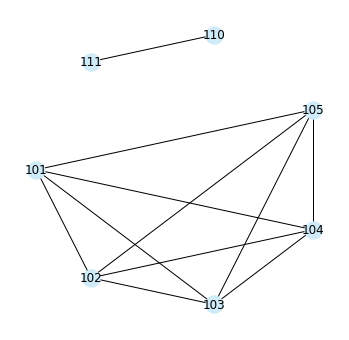

In [ ]:
from helpers import plot_graph

plot_graph(graph)

In [ ]:
list(graph.neighbors("101"))

['102', '103', '104', '105']

In [ ]:
graph.adj

AdjacencyView({'101': {'102': {'weight': 0.86}, '103': {'weight': 0.72}, '104': {'weight': 0.2}, '105': {'type': 'indirect may', 'weight': 0.2}}, '102': {'101': {'weight': 0.86}, '103': {'weight': 0.86}, '104': {'weight': 0.2}, '105': {'weight': 0.72}}, '103': {'101': {'weight': 0.72}, '102': {'weight': 0.86}, '104': {'weight': 0.3}, '105': {'weight': 0.5}}, '104': {'101': {'weight': 0.2}, '102': {'weight': 0.2}, '103': {'weight': 0.3}, '105': {'weight': 0}}, '105': {'102': {'weight': 0.72}, '103': {'weight': 0.5}, '104': {'weight': 0}, '101': {'type': 'indirect may', 'weight': 0.2}}, '110': {'111': {'weight': 0.9}}, '111': {'110': {'weight': 0.9}}})